 # Jednoduchý 1D hydrodynamický kód
 
 ## Základní rovnice hydrodynamiky

K popisu pohybu kontinua můžeme použít dva alternativní přístupy, Eulerův popis a Langrangeův popis. V Eulerově popisu je pohyb popsán vůči pevnému souřadnicovému systému (ne nutně inerciálnímu). Hydrodynamické rovnice jsou potom parciální diferenciální rovnice vzhledem k prostoru a času, popisující vývoj jednotlivých hydrodynamických veličin. Naproti tomu v Lagrangeově popisu je celé kontinuum rozděleno na určité elementární části objemu a je sledován pohyb každé této elementární části. Oba dva tyto přístupy mají své výhody a nevýhody. V našem popisu a kódu se omezíme na první, tedy Eulerův přístup.

Nejprve zavedeme značení jednotlivých hydrodynamických veličin, kterého se budeme držet v celém dalším textu. Základními hydrodynamickými veličinami jsou skalární hustota $\rho$, tlak $p$, vektorová rychlost elementu kontinua $\vec{v}$ a vnitřní energie plynu $U$. Tyto veličiny jsou vzájemně svázány pomocí hydrodynamických rovnic. Dále se v našem přístupu omezíme na ideální tekutinu, nebudeme tedy započítávat vazkost tekutiny. To je v případě drtivé většiny astrofyzikálních aplikací zcela oprávněná aproximace. V~takovém případě lze kontiunum popsat Eulerovými rovnicemi: rovnicí kontinuity, rovnicí pro hybnost a rovnicí pro energii.

<p style="text-align: center;">
    <img src="./Images/hydrodynamics.png" width=300px>
    <br>
    <em>Snapshots of mass flows in a binary white dwar - neutron stars with a 0.15 MWD, and 1.4 MNS, and e=0.04 (see more <a href=https://arxiv.org/pdf/1702.02377.pdf>[Bobrick et al. (2017)]</a>.</em> 

### **Paralelní výpočty**###

Hydrodynamické výpočty patří mezi výpočetně velmi náročné úlohy, nejen z hlediska nároků na pamět ale především z hlediska výpočetního výkonu, počtu matematických operací za jednotku času. Při simulaci reálných problémů se většinou využívá superpočítačů, ve kterých se výpočetní úloha paralelizovala na více procesorů. Díky technologickému pokroku se takový superpočítač nachází i na vašem stole, většina moderních počítačů má v sobě procesory více jader, na kterých můžeme provádět samostatné výpočty. Vhodnou algoritmizací úlohy, může paralelizace výrazně zkrátit výpočetní dobu programu.

Paralelizaci si můžeme jednoduše ukázat i v prostředí *Jupyter* s použitím balíku [*IPython Parallel*] (https://ipyparallel.readthedocs.io/en/latest/process.html). Pokud jej nemáte naistalované, doinstalujte je s pomocí příkazu 

`pip install ipyparallel` 

a následně povolte rozšíření *ipyparallel* v prostředí *Jupyter* příkazy


`jupyter serverextension enable --py ipyparallel
 jupyter nbextension install --py ipyparallel
 jupyter nbextension enable --py ipyparallel`

 spustťe kontroler příkazem
 
`ipcluster start --n=4`

kde $n$ vyjadřuje počet procesorů (jader). Více informací o paralelizaci na stránkách [Paralle Magic Command](https://ipython.org/ipython-doc/stable/parallel/magics.html)

### Nastavení výpočetní sítě (diskretizace)

*Fortran* array starting from 1 .. number of points + 4

*Python* numpy array starting from 0 .. number of points + 3

'0 0 1 1 2 2 3 3 4 4 ...i  i i+1...ig+1 ig+1 ig+2 ig+2 ig+3 ig+3'  
'| : | : | : | : | : |  |  :  |      |    :    |    :    |    :'  
'  S S B B I I I I I I  I     I      I    I    B    B    S    S'  
  
where *S* mean symmetry points, *B* boundary points and *I* inner points

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

import os
import ipyparallel as ipp
rc = ipp.Client()

all_engines = rc[:]
view = rc.load_balanced_view()

In [7]:
%px %pylab inline

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib
[stdout:2] Populating the interactive namespace from numpy and matplotlib
[stdout:3] Populating the interactive namespace from numpy and matplotlib


In [2]:
class Hydro1D:
    
    def __init__(self, number_of_points=100, time_end=200., xmin=1.0, xmax=10.0, sound_speed = 1.0, cfl=0.2, vi1=2./9.,\
                 subsonic_inflow = True, subsonic_outflow = False, viscosity =0.0):
        '''
        Initializing of the internal variables and settings parameters of the problem
        
        Parameters:
        -----------
        
        number_of_points:       integer type         number of grid points
        xmin,xmax:              integer type         minimal and maximal physical value of on x-grid
        
        subsonic_inflow         boolean type         boundary condition according to characteristics, 
                                                     true value mean that density on inner boundary
                                                     is fixed and momentum flux is extrapolated, false
                                                     mean both variables are fixed
                                                     
        subsonic_outflow        boolean type         boundary condition according to characteristics,
                                                     true value mean that density on outer boundary mean
                                                     is fixed and momentum flux is extrapolated, false 
                                                     mean both variables ar fixed
        
        viscosity               float type           setting value of numerical viscosity
        '''
        self.number_of_points = number_of_points
        self.time_end = time_end
        
        self.xmin = xmin
        self.xmax = xmax
        
        self.subsonic_inflow = subsonic_inflow
        self.subsonic_outflow = subsonic_outflow

        self.rho = np.empty(number_of_points+4)
        self.rho_u = np.empty(number_of_points+4)

        self.u_a = np.empty(number_of_points+4)
        self.u_b = np.empty(number_of_points+4)

        self.g = np.zeros(number_of_points+4)
        
        self.dv_a = np.empty(number_of_points+4)
        self.dv_b = np.empty(number_of_points+4)
        
        self.ti = 0.
        self.dt = 0.
        
        self.number_of_output = 50
        self.time_output = 0.
        self.time_step_output = self.time_end/self.number_of_output
        
        self.vi1 = vi1
        
        self.a = sound_speed
        self.cfl = cfl
        
        self.vis = viscosity
        self.is_radforce = False
        

    def grid(self):
        ''' 
        Method fo generating 1D - spherical spatial mesh. Scalars (r) reside at cell centers (termed b),
        vectors (ru) at cell interfaces (termed a)
        
        self.x_a         spatial coordinate zone-faces
        self.x_b         spatial coordinate zone-centers
        
        self.df_a        interface area zone-faces
        self.df_a        interface area zone-centers
        
        self.dv_a        spherical volume zone-faces        
        self.dv_b        spherical volume zone-centers
        
        Spherical volume is volume of the shell between two x-grid points
        '''
    
        step = (self.xmax - self.xmin)/self.number_of_points
        self.x_a = np.linspace(self.xmin - 2.0*step,self.xmax+step,self.number_of_points+4)
    
        start = (self.x_a[0]+self.x_a[1])/2.0
        end = (self.x_a[self.number_of_points+2]+self.x_a[self.number_of_points+3])/2.0
        self.x_b = np.linspace(start,end+step,self.number_of_points+4)

        self.df_a = self.x_a**2.0
        self.df_b = self.x_b**2.0
    
        self.dv_a[1:] = (self.x_b[1:]**3.0-self.x_b[:self.number_of_points+3]**3.0)/3.0
        self.dv_a[0] = self.dv_a[1]
    
        self.dv_b[:self.number_of_points+3] = (self.x_a[1:]**3.0-self.x_a[:self.number_of_points+3]**3.0)/3.0
        self.dv_b[self.number_of_points+3] = self.dv_b[self.number_of_points+2]
    
        return 
    
    def van_leer_rho(self):
        '''
        
        van Leer (1977) advection for density rho (b grid) for 1D

        '''
        ri = np.zeros(self.number_of_points+4)
    
        for i in range(2,self.number_of_points+3):
        
            if self.u_a[i] > 0.:
                ii = i - 1
            else:
                ii = i
        
            dm = (self.rho[ii]-self.rho[ii-1])/(self.x_b[ii]-self.x_b[ii-1])
            dp = (self.rho[ii+1]-self.rho[ii])/(self.x_b[ii+1]-self.x_b[ii])
        
            dd = dm*dp
        
            if dd > 0:
                vl = 2.0*dd/(dm+dp)
            else:
                vl = 0.
            
            ri[i] = self.rho[ii]+vl*(self.x_a[i]-self.x_b[ii]-self.u_a[i]*self.dt/2.0)
        
        self.rho[2:self.number_of_points+2] = self.rho[2:self.number_of_points+2]-self.dt/self.dv_b[2:self.number_of_points+2]* \
        (ri[3:self.number_of_points+3]*self.u_a[3:self.number_of_points+3]*self.df_a[3:self.number_of_points+3]-\
         ri[2:self.number_of_points+2]*self.u_a[2:self.number_of_points+2]*self.df_a[2:self.number_of_points+2])
            
        return
    
    def van_leer_rho_u(self):
        '''
        
        van Leer (1977) advection for momentum density rho_u (a grid) for 1D

        '''
        rui = np.zeros(self.number_of_points+4)
        
        for i in range (2,self.number_of_points+2):
        
            if self.u_b[i] > 0:
                ii = i
            else:
                ii = i + 1
        
            dm = (self.rho_u[ii]-self.rho_u[ii-1])/(self.x_a[ii]-self.x_a[ii-1])
            dp = (self.rho_u[ii+1]-self.rho_u[ii])/(self.x_a[ii+1]-self.x_a[ii])
        
            dd = dm*dp
        
            if dd > 0:
                vl = 2.*dd/(dm+dp)
            else:
                vl = 0.
        
            rui[i] = self.rho_u[ii]+vl*(self.x_b[i]-self.x_a[ii]-self.u_b[i]*self.dt/2.0)
        
        self.rho_u[3:self.number_of_points+2] = self.rho_u[3:self.number_of_points+2]-self.dt/self.dv_a[3:self.number_of_points+2]* \
        (rui[3:self.number_of_points+2]*self.u_b[3:self.number_of_points+2]*self.df_b[3:self.number_of_points+2]-\
        rui[2:self.number_of_points+1]*self.u_b[2:self.number_of_points+1]*self.df_b[2:self.number_of_points+1])
    
        return

    def boundary(self):
    
    # Inflow subsonic
        if self.subsonic_inflow:
            self.rho[1] = self.rho[1]
            self.rho_u[2] = self.rho_u[3]
        
    # Inflow supersonic
        else:
            rho[1] = rho[1]
            rho_u[2] = rho_u[2]
    
    # Outflow subsonic
    
        if self.subsonic_outflow:
            self.rho[self.number_of_points+2] = self.rho[self.number_of_points+1]
            self.rho_u[self.number_of_points+2] = self.rho_u[self.number_of_points+2]
        else:
            self.rho[self.number_of_points+2] = self.rho[self.number_of_points+1]
            self.rho_u[self.number_of_points+2] = self.rho_u[self.number_of_points+1]
    
        self.rho[0] = self.rho[1]
        self.rho[self.number_of_points+3] = self.rho[self.number_of_points+2]
    
        self.rho_u[1] = self.rho_u[2]
        self.rho_u[self.number_of_points+3] = self.rho_u[self.number_of_points+2]

        return

    def speed(self):
        '''
    
        Linear interpolation of the advection speed to the a,b grid 
    
        '''
        self.u_a[2:self.number_of_points+3]=2.0*self.rho_u[2:self.number_of_points+3]/(self.rho[1:self.number_of_points+2]+self.rho[2:self.number_of_points+3])
        self.u_b[2:self.number_of_points+2]=(self.u_a[2:self.number_of_points+2]+self.u_a[3:self.number_of_points+3])/2.0
    
        return
    
    def clock(self):
        '''
    
        Method for setting time step according to the Courant condition of 
        stability. Negative Courant number means fixed time step
    
       dt < = cfl * dx / (u + a)
    
        '''
        if self.cfl < 0.:
            self.dt = -self.cfl
        else:
            dtt = np.empty(self.number_of_points+4)
    
            dtt[2:self.number_of_points+2] = self.cfl*(self.x_a[3:self.number_of_points+3]-\
                        self.x_a[2:self.number_of_points+2])/(np.abs(self.u_b[2:self.number_of_points+2])+self.a)
    
            self.dt = np.min(dtt[2:self.number_of_points+2])
    
        self.ti = self.ti + self.dt
    
        return

    def pressure(self):
        '''
        Method calculate pressure on scalar mesh
        ''' 
        b = np.copy(self.rho_u)
        b[3:self.number_of_points+2]=self.rho_u[3:self.number_of_points+2]-self.a**2.0*self.dt*\
        (self.rho[3:self.number_of_points+2]-self.rho[2:self.number_of_points+1])/\
        (self.x_b[3:self.number_of_points+2]-self.x_b[2:self.number_of_points+1])
        
        return b

    def gravity(self):
        b = np.copy(self.rho_u)
        b[3:self.number_of_points+2]=self.rho_u[3:self.number_of_points+2]-self.dt*(self.rho[2:self.number_of_points+1]\
                                        +self.rho[3:self.number_of_points+2])/2.*self.g[3:self.number_of_points+2]
        return b

    def radforce(self):
        b = np.copy(self.rho_u)
        rgl = np.empty(self.number_of_points+4)
    
        rgl[3:self.number_of_points+2] = self.vi1*np.sqrt(0.5*(self.rho[2:self.number_of_points+1]+self.rho[3:self.number_of_points+2])*\
        np.abs(self.u_b[3:self.number_of_points+2]-self.u_b[2:self.number_of_points+1])/(self.x_b[3:self.number_of_points+2]-self.x_b[2:self.number_of_points+1]))
    
        rgl[3:self.number_of_points+2] = rgl[3:self.number_of_points+2]/self.x_a[3:self.number_of_points+2]**2
    
        b[3:self.number_of_points+2] =  self.rho_u[3:self.number_of_points+2]+self.dt*rgl[3:self.number_of_points+2]
    
        return b

    def visco(self):
        '''
        Add artifical viscosity to solver which helps us to keep stability of the code (shock waves, discontinuity)
        '''
        self.vis = 0.0
        q = np.empty(number_of_points+4)
    
        q[2:self.number_of_points+2]=self.rho[2:self.number_of_points+2]*\
        self.vis*np.minimum(0,self.u_a[3:self.number_of_points+3]-self.u_a[2:self.number_of_points+2])**2
    
        self.rho_u[3:self.number_of_points+2] = self.rho_u[3:self.number_of_points+2]-self.dt*((q[3:self.number_of_points+2]-\
                    q[2:self.number_of_points+1])/(self.x_b[3:self.number_of_points+2]-self.x_b[2:self.number_of_points+1]))
        return
    
    def initial(self,f):
    
        self.rho, self.rho_u = f
        
        # Reduction at ghost cell
        self.rho[0] = self.rho[1]
        self.rho_u[1] = self.rho_u[2]
        self.rho[self.number_of_points+3] = self.rho[self.number_of_points+2]
        self.rho_u[self.number_of_points+3] = self.rho_u[self.number_of_points+2]
        
        return 
    
    def setup_gravity(self,g):
        
        self.g = g
        
        return 

    def initial_solar(self):

        int1=np.int(self.number_of_points/(2.*self.vi1*self.xmax)-1)
        self.rho[:int1+1] = np.exp((1./self.x_b[:int1+1]-1./self.xmin)/self.vi1)
    
        au1 = self.rho[int1]*self.x_b[int1]**2
        self.rho[int1+1:self.number_of_points+3] = au1/self.x_b[int1+1:self.number_of_points+3]**2
    
        au1 = np.sqrt(2./self.vi1)
        self.rho_u[1:self.number_of_points+3]=self.rho[1:self.number_of_points+3]*(0.1+0.1*au1*\
               (self.x_a[1:self.number_of_points+3]-self.xmin)/(self.xmax-self.xmin))
    
    
        self.rho[self.number_of_points+3] = self.rho[self.number_of_points+2]
        return self.rho,self.rho_u
    
    def initial_cak(self):
        self.vi2 = 1.0
        self.is_radforce = True
        c =  np.copy(self.rho)
        b = np.copy(self.rho_u)
        
        b = self.vi2/self.x_a**2
        
        au1 = 0.0
        au2 = 0.0
        
        for i in range(self.number_of_points+4):
            if au1 < self.a:
                
                au2 = self.x_b[i]
                au1 = self.a/10.*np.exp((au2-self.xmin)/self.a**2)
                
            else:
                au1 = self.a+2.*(self.x_b[i]-au2)/(self.xmax-au2)
        
            c[i] = self.vi2/au1/self.x_b[i]**2
            
        return c,b
    
    def setup_gravity_solar(self):
        return 1./(self.vi1*self.x_a**2.0)
    
    def setup_gravity_cak(self):
        return 1./self.x_a**2.0

    
    def store_data_netCDF(self):
        print(self.ti)
        return
    
    def output(self):
        if self.ti > self.time_output:
            self.store_data_netCDF()
            self.time_output = self.time_output + self.time_step_output
        if self.ti > self.time_end:
            self.is_not_end = False
        return 
            
    def print_output(self):
            
        x = np.empty(self.number_of_points+4)
        u = np.empty(self.number_of_points+4)
        
        x[2:self.number_of_points+2] = self.x_b[2:self.number_of_points+2]
        u[2:self.number_of_points+2] = 0.5*(self.rho_u[2:self.number_of_points+2]+self.rho_u[3:self.number_of_points+3])/ \
            (self.rho[2:self.number_of_points+2])

        return x[2:self.number_of_points+2],self.rho[2:self.number_of_points+2],u[2:self.number_of_points+2]
    
    def run(self):

        self.ti = 0.
        self.is_not_end = True

        while self.is_not_end:
            
            self.speed()
            self.clock()
            
            self.van_leer_rho()
            self.van_leer_rho_u()
            
            self.rho_u = self.pressure()
            self.rho_u = self.gravity()
            
            if self.is_radforce:
                self.rho_u = self.radforce()
            
            self.boundary()
            self.output()
            self.ti = self.ti + self.dt
        return
    

## Hvězdný vítr hnaný zářením

In [3]:
# Run code with choosen set of parameters
g = Hydro1D(number_of_points=400,time_end=50.,xmin=1.0,xmax=5.0,sound_speed=0.1,cfl=0.35,vi1=2.0)

# Init block of the astrophysical pp
g.grid()
g.g = g.setup_gravity_cak()
g.initial(g.initial_cak())

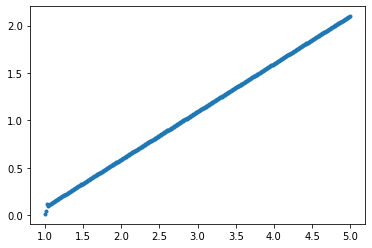

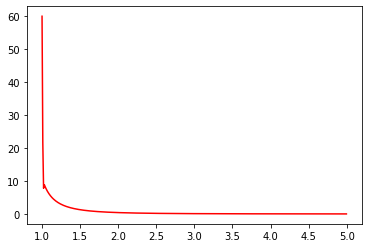

In [4]:
g.g = g.setup_gravity_cak()
g.initial(g.initial_cak())

x,rho,vel = g.print_output()

plt.plot(x,vel,'.')
plt.show()

plt.plot(x,rho,'r-')
plt.show()

Nic nám už nebrání ve spuštění simulace slunečního větru

In [6]:
%px 
g.run()

0.0015927408022883617
1.0008040608788635
2.000882179367182
3.000128768177568
4.004167109956498
5.003126145696811
6.001035141227889
7.001017436046922
8.003167863498879
9.003030756147
10.000959572510345
11.002414172289189
12.00237270157837
13.000444767082975
14.002079258582565
15.001859290426875
16.00032870555705
17.005248750518124
18.00412214743522
19.00058867331569
20.000905614776322
21.004046089961797
22.004315628763756
23.001431933265188
24.000476363893
25.00124055601553
26.003503471540615
27.0015825459948
28.000787437443396
29.00096734965217
30.00198897914822
31.003733393659886
32.00058414653318
33.00346039015757
34.00125568187083
35.004917291544345
36.00334588491879
37.00199192323542
38.00079796318988
39.00523082343429
40.00420496687752
41.003195594180276
42.002163045676845
43.00107104287295
44.005404363747644
45.004095787207845
46.00263597830813
47.00099928174163
48.00467623353139
49.00261564047347
50.0003128491775


Po skončení simulace se podíváme na výsledek simulace, zda odpovídá našemu předpokládanému výsledku, tedy *hvězdnému větru hnaného zářením*. Je zapotřebí si uvědomit, že rychlost i poloha (tedy vzdálenost od Slunce) jsou uváděny v bezrozměrných jednotkách.

Text(0.5, 0, 'r/R_s')

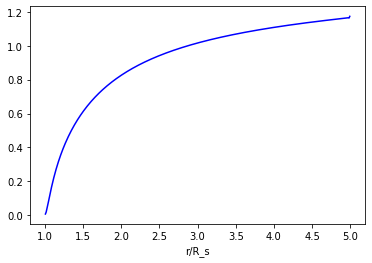

In [9]:
x,rho,u = g.print_output()

plt.plot(x,u,'b-')
plt.xlabel('r/R_s')
plt.ylabel('u')

In [32]:
g = Hydro1D(number_of_points=100,time_end=50.,xmin=1.0,xmax=10.0,sound_speed=1.0,cfl=0.4,vi1=2./9.)
g.grid()

### **Sluneční vítr**

Před spuštěním simulace je nutné zvolit vhodné počáteční podmínky, tak aby mohl systém snadno dokonvergovat ke stacionárnímu řešení, které bude reprezentovat [**Parkerův sluneční vítr**](./PDF/solar_wind.pdf)

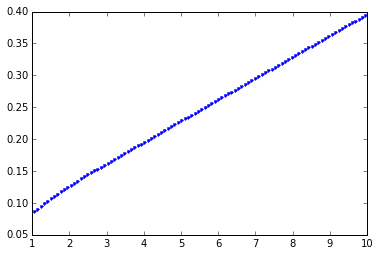

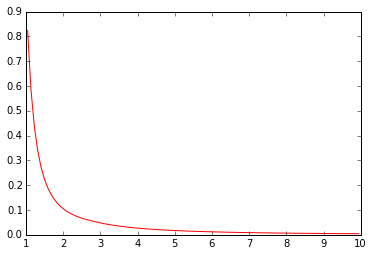

In [33]:
g.g = g.setup_gravity_solar()
g.initial(g.initial_solar())

x,rho,vel = g.print_output()

## Initial profile of velocity
plt.plot(x,vel,'.')
plt.show()

plt.plot(x,rho,'r-')
plt.show()

In [ ]:
###

In [35]:
%px 
g.run()

0.0258083507172
1.02574250039
2.00705867107
3.00857499521
4.02047009543
5.00047447982
6.02335673524
7.02359578077
8.01596719195
9.01762213024
10.0264824324
11.0036321167
12.0028098306
13.022920359
14.0273809024
15.0104006915
16.0063734696
17.0181923245
18.0168175356
19.0017548816
20.023739677
21.0216787261
22.0233540326
23.0032126653
24.0128238879
25.0017247753
26.0194733733
27.0177200761
28.020129754
29.0003900224
30.0065452682
31.0197453365
32.0004770902
33.0172409562
34.0072028816
35.0149953137
36.0201301507
37.0020263418
38.0038958159
39.0047532999
40.0048698647
41.0044411114
42.0036093257
43.0024787873
44.0011264246
45.0208521215
46.0192103303
47.017478277
48.0156793227
49.0138308572
50.0119458086


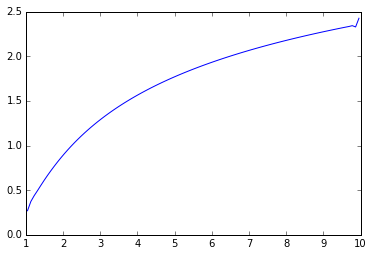

In [36]:
x,rho,u = g.print_output()

plt.plot(x,u,'b-')

In [34]:
import profile; profile.help()

Documentation for the profile module can be found 
in the Python Library Reference, section 'The Python Profiler'.
